1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# TensorFlow/Keras LSTM-modellhez
import tensorflow as tf
import keras as krs
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Sklearn preprocessing marad az eredeti pipeline-hoz
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"

# betöltés
df = pd.read_csv(file_path, usecols=usecols)

# mérkőzésindex és forduló hozzárendelése (10 meccs/forduló)
df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

# óraintervallum kinyerése és TimeOfDay címkék
df['Hour'] = (
    pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
      .dt.hour
)
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)

# felesleges Hour oszlop eltávolítása
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# %%
# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# %%
# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# %%
# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1)
                           .rolling(3, min_periods=1)
                           .mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1)
                           .rolling(3, min_periods=1)
                           .mean())
)

# %%
# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# %%
# 3.6 Interaction term
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# %%
# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# %%
# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

4. Preprocessing and LSTM Model Specification with Hyperparameter Distributions

In [4]:
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import layers, Model

# 4.1) safety: ensure feature lists exist (reconstruct if previous cell not run)
if 'cat_feats' not in globals() or 'num_feats' not in globals():
    cat_feats = [c for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay'] if c in df.columns]
    base_num = [
        'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
        'ImpProb_H','ImpProb_D','ImpProb_A',
        'ImpOver2.5','ImpUnder2.5','OddsSpread','Spread×Form',
        'RefBias','H2H_Last','HomePosPrev','AwayPosPrev'
    ]
    home_stats = ['HS','HST','HF','HC','HY','HR']
    away_stats = ['AS','AST','AF','AC','AY','AR']
    roll_num = [f'Home_{s}_3' for s in home_stats if f'Home_{s}_3' in df.columns] + \
               [f'Away_{s}_3' for s in away_stats if f'Away_{s}_3' in df.columns]
    num_feats = [c for c in base_num + roll_num if c in df.columns]

# 4.2) outcome mapping for Keras (−1,0,1) → (0,1,2)
label2idx = {-1: 0, 0: 1, 1: 2}
idx2label = {v: k for k, v in label2idx.items()}

# 4.3) define sequence feature PAIRS dynamically (only if both sides exist)
# (logical_key, home_col, away_col)
desired_pairs = [
    ('Form3',   'HomeForm3',   'AwayForm3'),
    ('Streak',  'HomeStreak',  'AwayStreak'),
    ('Shots3',  'Home_HS_3',   'Away_AS_3'),
    ('SOT3',    'Home_HST_3',  'Away_AST_3'),
    ('Fouls3',  'Home_HF_3',   'Away_AF_3'),
    ('Corners3','Home_HC_3',   'Away_AC_3'),
    ('Yellows3','Home_HY_3',   'Away_AY_3'),
    ('Reds3',   'Home_HR_3',   'Away_AR_3'),
]
seq_pairs = [(k, h, a) for (k, h, a) in desired_pairs if (h in df.columns and a in df.columns)]
if not seq_pairs:
    fallback = [('Form3','HomeForm3','AwayForm3'), ('Streak','HomeStreak','AwayStreak')]
    seq_pairs = [(k, h, a) for (k, h, a) in fallback if (h in df.columns and a in df.columns)]
if not seq_pairs:
    raise ValueError("No valid sequence features found. Ensure at least HomeForm3/AwayForm3 (and/or Streak) exist in point 3.")

F_SEQ = len(seq_pairs)           # number of sequence features
SEQ_WINDOW = 8                   # time window (can try 5/10 later)

# 4.4) chronological match indices per team
def _team_match_indices(df_in: pd.DataFrame) -> dict:
    team_rows = defaultdict(list)
    for i, r in df_in.iterrows():
        team_rows[r['HomeTeam']].append(i)
        team_rows[r['AwayTeam']].append(i)
    for t in team_rows:
        team_rows[t] = sorted(team_rows[t], key=lambda ridx: df_in.loc[ridx, 'Round'])
    return team_rows

team_rows_map = _team_match_indices(df)

# 4.5) one row → feature vector for a GIVEN team (chooses home/away column by role)
def _row_team_vector(r_idx: int, team_name: str) -> np.ndarray:
    row = df.loc[r_idx]
    is_home = (row['HomeTeam'] == team_name)
    vals = []
    for _, hcol, acol in seq_pairs:
        col = hcol if is_home else acol
        v = row[col] if col in row and pd.notna(row[col]) else 0.0
        try:
            vals.append(float(v))
        except Exception:
            vals.append(0.0)
    return np.asarray(vals, dtype=float)

# 4.6) build windowed sequences (strictly past T matches) for a team across its matches
def build_team_sequences_for_rows(team_name: str, T: int) -> np.ndarray:
    rows = team_rows_map[team_name]
    out = np.zeros((len(rows), T, F_SEQ), dtype=float)
    for i_in_team, r_idx in enumerate(rows):
        past_rows = rows[max(0, i_in_team - T):i_in_team]  # strictly before current
        window_vecs = [_row_team_vector(pr, team_name) for pr in past_rows]
        window = np.vstack(window_vecs) if window_vecs else np.empty((0, F_SEQ))
        pad = SEQ_WINDOW - window.shape[0]
        if pad > 0:
            window = np.vstack([np.zeros((pad, F_SEQ)), window])
        out[i_in_team] = window
    return out  # (N_team_matches, T, F_SEQ)

# 4.7) static (non-sequence) features for the current match (no time leakage)
static_num_cols = [c for c in [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread','Spread×Form',
    'RefBias','H2H_Last','HomePosPrev','AwayPosPrev'
] if c in df.columns]
static_cat_cols = [c for c in ['Referee','TimeOfDay'] if c in df.columns]

static_preproc = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0)),
                          ('scale', StandardScaler())]), static_num_cols),
        ('cat', Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), static_cat_cols)
    ],
    remainder='drop',
    sparse_threshold=0.0
)

# 4.8) LSTM model factory (shared encoder for home/away, then static concat)
def make_lstm_model(T: int, F_seq: int, F_static: int) -> Model:
    inp_h = layers.Input(shape=(T, F_seq), name='home_seq')
    inp_a = layers.Input(shape=(T, F_seq), name='away_seq')
    inp_s = layers.Input(shape=(F_static,), name='x_static')

    mask_h = layers.Masking(mask_value=0.0)(inp_h)
    mask_a = layers.Masking(mask_value=0.0)(inp_a)

    shared_lstm = layers.LSTM(64, dropout=0.2, recurrent_dropout=0.1, return_sequences=False)
    h_vec = shared_lstm(mask_h)
    a_vec = shared_lstm(mask_a)

    x = layers.Concatenate()([h_vec, a_vec, inp_s])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=[inp_h, inp_a, inp_s], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 4.9) utilities: scale sequences leakage-safely and compute class weights
def fit_transform_sequences(seq_array: np.ndarray, scaler: StandardScaler | None = None):
    """
    seq_array: (N, T, F). We scale features across the (N*T, F) flattened view.
    Returns scaled array and fitted scaler.
    """
    if seq_array.size == 0:
        return seq_array, StandardScaler() if scaler is None else scaler
    N, T, F = seq_array.shape
    Xf = seq_array.reshape(-1, F)
    if scaler is None:
        scaler = StandardScaler()
        Xf_scaled = scaler.fit_transform(Xf)
    else:
        Xf_scaled = scaler.transform(Xf)
    return Xf_scaled.reshape(N, T, F), scaler

def compute_class_weights(y_int: np.ndarray) -> dict:
    # y_int in {0,1,2}
    if y_int.size == 0:
        return {0:1.0, 1:1.0, 2:1.0}
    vals, counts = np.unique(y_int, return_counts=True)
    total = counts.sum()
    weights = {int(v): float(total / (len(vals) * c)) for v, c in zip(vals, counts)}
    for k in [0,1,2]:
        weights.setdefault(k, 1.0)
    return weights


5. Round-by-Round Loop with RandomizedSearchCV (LSTM)

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np

# 5.1) containers
preds, actuals, rounds, match_indices = [], [], [], []

# 5.2) helpers: build sequences for a slice of rows (train/val/test)
def _rows_to_sequences(mask):
    """
    For a boolean mask of rows (train/val/test slice), build:
      - home_seq: (N, T, F_SEQ)
      - away_seq: (N, T, F_SEQ)
      - y:        (N,)   mapped labels (−1,0,1 → 0,1,2)
      - idx:      list of row indices in time order
    """
    rows = df.loc[mask, :].sort_values(['Round','MatchIndex'])
    home_seq_list, away_seq_list, y_list, idx_list = [], [], [], []

    for i, r in rows.iterrows():
        home_team = r['HomeTeam']; away_team = r['AwayTeam']
        h_rows = team_rows_map.get(home_team, [])
        a_rows = team_rows_map.get(away_team, [])
        if i not in h_rows or i not in a_rows:
            continue  # safety, should not happen

        h_pos = h_rows.index(i)
        a_pos = a_rows.index(i)

        h_past = h_rows[max(0, h_pos - SEQ_WINDOW):h_pos]
        a_past = a_rows[max(0, a_pos - SEQ_WINDOW):a_pos]

        h_vecs = [_row_team_vector(pr, home_team) for pr in h_past]
        a_vecs = [_row_team_vector(pr, away_team) for pr in a_past]

        h_win = np.vstack(h_vecs) if h_vecs else np.empty((0, F_SEQ))
        a_win = np.vstack(a_vecs) if a_vecs else np.empty((0, F_SEQ))

        if h_win.shape[0] < SEQ_WINDOW:
            h_win = np.vstack([np.zeros((SEQ_WINDOW - h_win.shape[0], F_SEQ)), h_win])
        if a_win.shape[0] < SEQ_WINDOW:
            a_win = np.vstack([np.zeros((SEQ_WINDOW - a_win.shape[0], F_SEQ)), a_win])

        home_seq_list.append(h_win)
        away_seq_list.append(a_win)
        y_list.append(r['Outcome'])
        idx_list.append(i)

    Xh = np.stack(home_seq_list, axis=0) if home_seq_list else np.zeros((0, SEQ_WINDOW, F_SEQ))
    Xa = np.stack(away_seq_list, axis=0) if away_seq_list else np.zeros((0, SEQ_WINDOW, F_SEQ))
    y  = pd.Series(y_list).map(label2idx).to_numpy()
    idx = idx_list
    return Xh, Xa, y, idx

# 5.3) warm-up (first 5 rounds) with time-ordered validation (for early stopping)
WARMUP_ROUNDS  = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

warm_mask_all = df.index < WARMUP_MATCHES
val_mask_warm = (df['Round'] == WARMUP_ROUNDS) & warm_mask_all
if val_mask_warm.sum() >= 10:
    train_mask_warm = warm_mask_all & (~val_mask_warm)
else:
    # fallback: last 10% as validation
    warm_rows_sorted = df.loc[warm_mask_all].sort_values(['Round','MatchIndex']).index
    split_idx = int(len(warm_rows_sorted) * 0.9)
    val_mask_warm = df.index.isin(warm_rows_sorted[split_idx:])
    train_mask_warm = df.index.isin(warm_rows_sorted[:split_idx])

# static features (fit on warm-train only)
X_static_tr_w = static_preproc.fit_transform(df.loc[train_mask_warm, :])
X_static_va_w = static_preproc.transform(df.loc[val_mask_warm, :])

# sequences
Xh_tr_w, Xa_tr_w, y_tr_w, idx_tr_w = _rows_to_sequences(train_mask_warm)
Xh_va_w, Xa_va_w, y_va_w, idx_va_w = _rows_to_sequences(val_mask_warm)

# scale sequences using warm-train only
Xh_tr_w, seq_scaler = fit_transform_sequences(Xh_tr_w, scaler=None)
Xa_tr_w, _          = fit_transform_sequences(Xa_tr_w, scaler=seq_scaler)
Xh_va_w, _          = fit_transform_sequences(Xh_va_w, scaler=seq_scaler)
Xa_va_w, _          = fit_transform_sequences(Xa_va_w, scaler=seq_scaler)

# model build & warm-up fit
F_static = X_static_tr_w.shape[1] if X_static_tr_w.ndim == 2 else 0
lstm_w = make_lstm_model(T=SEQ_WINDOW, F_seq=F_SEQ, F_static=F_static)

cw_w = compute_class_weights(y_tr_w)
es_cb = tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', restore_best_weights=True)

_ = lstm_w.fit(
    x=[Xh_tr_w, Xa_tr_w, X_static_tr_w],
    y=y_tr_w,
    validation_data=([Xh_va_w, Xa_va_w, X_static_va_w], y_va_w),
    epochs=80, batch_size=64, verbose=0,
    class_weight=cw_w,
    callbacks=[es_cb]
)

# 5.4) predict from round 6 onward (always 10 matches per round)
from numpy import vectorize

preds, actuals, rounds, match_indices = [], [], [], []
max_round = int(df['Round'].max())

for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # enforce exactly 10 test matches
    round_df = df.loc[test_mask, :].sort_values(['Round','MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
        test_mask = df.index.isin(round_df.index)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    # validation = last full round r-1 if available, else last 10% of train
    val_mask = (df['Round'] == (r - 1)) & train_mask
    if val_mask.sum() < 10:
        tr_rows_sorted = df.loc[train_mask, :].sort_values(['Round','MatchIndex']).index
        split_idx = int(len(tr_rows_sorted) * 0.9)
        val_mask = df.index.isin(tr_rows_sorted[split_idx:])
        train_mask = df.index.isin(tr_rows_sorted[:split_idx])
    else:
        train_mask = train_mask & (~val_mask)

    # static features (fit on train only)
    X_static_tr = static_preproc.fit_transform(df.loc[train_mask, :])
    X_static_va = static_preproc.transform(df.loc[val_mask, :])
    X_static_te = static_preproc.transform(df.loc[test_mask, :])

    # sequences for train/val/test
    Xh_tr, Xa_tr, y_tr, idx_tr = _rows_to_sequences(train_mask)
    Xh_va, Xa_va, y_va, idx_va = _rows_to_sequences(val_mask)
    Xh_te, Xa_te, y_te, idx_te = _rows_to_sequences(test_mask)

    # scale sequences using train-only scaler
    Xh_tr, seq_scaler = fit_transform_sequences(Xh_tr, scaler=None)
    Xa_tr, _          = fit_transform_sequences(Xa_tr, scaler=seq_scaler)
    Xh_va, _          = fit_transform_sequences(Xh_va, scaler=seq_scaler)
    Xa_va, _          = fit_transform_sequences(Xa_va, scaler=seq_scaler)
    Xh_te, _          = fit_transform_sequences(Xh_te, scaler=seq_scaler)
    Xa_te, _          = fit_transform_sequences(Xa_te, scaler=seq_scaler)

    # build & fit model for this round
    F_static = X_static_tr.shape[1] if X_static_tr.ndim == 2 else 0
    model = make_lstm_model(T=SEQ_WINDOW, F_seq=F_SEQ, F_static=F_static)

    cw = compute_class_weights(y_tr)
    es_cb = tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', restore_best_weights=True)

    print(f"Round {r}: train={len(idx_tr)} | val={len(idx_va)} | test=10 ...")
    _ = model.fit(
        x=[Xh_tr, Xa_tr, X_static_tr],
        y=y_tr,
        validation_data=([Xh_va, Xa_va, X_static_va], y_va),
        epochs=80, batch_size=64, verbose=0,
        class_weight=cw,
        callbacks=[es_cb]
    )

    # predict exactly 10 matches
    y_prob = model.predict([Xh_te, Xa_te, X_static_te], verbose=0)
    y_pred_idx = y_prob.argmax(axis=1)
    y_pred = vectorize(idx2label.get)(y_pred_idx)

    # collect
    preds.extend(y_pred.tolist())
    actuals.extend(vectorize(idx2label.get)(y_te).tolist())
    rounds.extend([r] * len(y_pred))          # always 10
    match_indices.extend(idx_te)

    # per-round accuracy (accuracy only)
    acc = accuracy_score(vectorize(idx2label.get)(y_te), y_pred)
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# 5.5) expose final trained model and last training round
final_model = model
last_train_round = max_round - 1


Round 6: train=40 | val=10 | test=10 ...
Round 6: 10 matches | accuracy = 0.200
Round 7: train=50 | val=10 | test=10 ...
Round 7: 10 matches | accuracy = 0.200
Round 8: train=60 | val=10 | test=10 ...
Round 8: 10 matches | accuracy = 0.700
Round 9: train=70 | val=10 | test=10 ...
Round 9: 10 matches | accuracy = 0.300
Round 10: train=80 | val=10 | test=10 ...
Round 10: 10 matches | accuracy = 0.500
Round 11: train=90 | val=10 | test=10 ...
Round 11: 10 matches | accuracy = 0.300
Round 12: train=100 | val=10 | test=10 ...
Round 12: 10 matches | accuracy = 0.100
Round 13: train=110 | val=10 | test=10 ...
Round 13: 10 matches | accuracy = 0.700
Round 14: train=120 | val=10 | test=10 ...
Round 14: 10 matches | accuracy = 0.700
Round 15: train=130 | val=10 | test=10 ...
Round 15: 10 matches | accuracy = 0.600
Round 16: train=140 | val=10 | test=10 ...
Round 16: 10 matches | accuracy = 0.700
Round 17: train=150 | val=10 | test=10 ...
Round 17: 10 matches | accuracy = 0.600
Round 18: train=16

6: Assemble and Save Results

In [6]:
import pandas as pd
import joblib

# 6.1 Build the results DataFrame
results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'Actual':      actuals,
    'Predicted':   preds
})
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

# 6.2 Compute overall and per-round accuracy
overall_acc = results_df['Correct'].mean()
print(f"Overall accuracy: {overall_acc:.3f}")

round_acc = (
    results_df
      .groupby('Round')['Correct']
      .mean()
      .reset_index(name='Accuracy')
)
print(round_acc)

# 6.3 Persist your results
results_df.to_csv('lstm_round_by_round_predictions.csv', index=False)
round_acc.to_csv('lstm_accuracy_by_round.csv', index=False)

# 6.4 Save the trained model for future inference
joblib.dump(final_model, 'final_lstm_model.pkl')

Overall accuracy: 0.485
    Round  Accuracy
0       6       0.2
1       7       0.2
2       8       0.7
3       9       0.3
4      10       0.5
5      11       0.3
6      12       0.1
7      13       0.7
8      14       0.7
9      15       0.6
10     16       0.7
11     17       0.6
12     18       0.5
13     19       0.1
14     20       0.6
15     21       0.2
16     22       0.5
17     23       0.5
18     24       0.3
19     25       0.8
20     26       0.6
21     27       0.6
22     28       0.5
23     29       0.5
24     30       0.6
25     31       0.4
26     32       0.3
27     33       0.5
28     34       0.3
29     35       0.5
30     36       0.9
31     37       0.5
32     38       0.7


['final_lstm_model.pkl']

7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_16004\1585225667.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


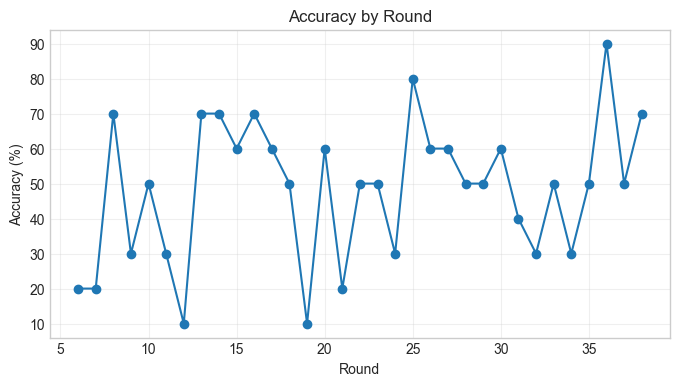

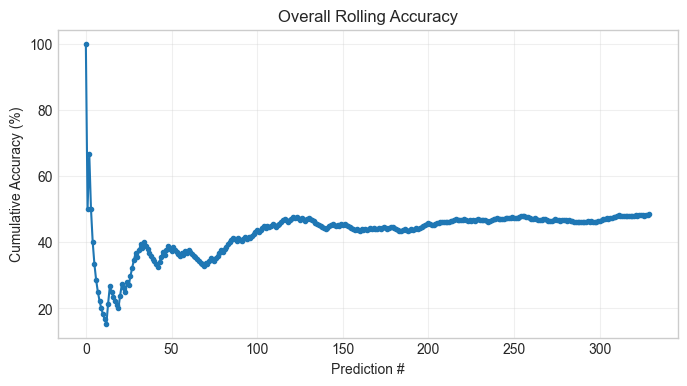

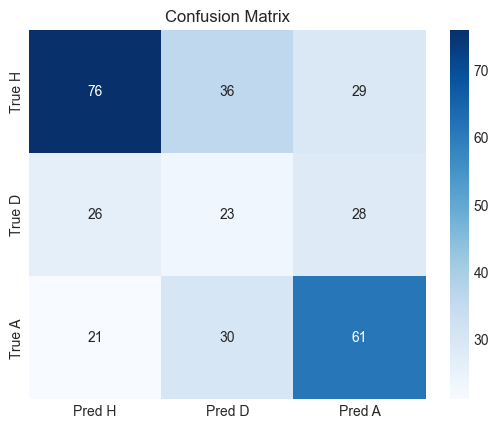


Overall accuracy (rounds 6–38): 0.485
Text summary: The model achieved an overall accuracy of 48.5% across rounds 6–38.


In [7]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# round-by-round accuracy
res = pd.DataFrame({'Round': rounds, 'Pred': preds, 'True': actuals})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))

plt.figure(figsize=(8,4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.show()

# cumulative accuracy
cum_acc = np.cumsum(np.array(preds) == np.array(actuals)) / np.arange(1, len(preds) + 1)
plt.figure(figsize=(8,4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Overall Rolling Accuracy')
plt.grid(alpha=0.3)
plt.show()

# confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1,0,-1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred H','Pred D','Pred A'],
            yticklabels=['True H','True D','True A'])
plt.title('Confusion Matrix')
plt.show()

# --- Overall accuracy (text) ---
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")

8. Gradio Interface

In [8]:
import gradio as gr
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Pull the last historical row for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble the feature dict
    data = {}
    
    # 2a) Odds-derived features: fill with their training-set means
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    
    # 2c) Interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    
    # 2e) Head-to-head last
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    
    # 2g) Rolling match-stats (shots, fouls, cards)
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) DataFrame and predict
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with their historical averages, "
        "all other features are pulled from past matches."
    )
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7879

To create a public link, set `share=True` in `launch()`.
